# A conditional GAN implementation
The following code is based on code by Jason Brownlee : https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/ 
As well as the code and tutorial by Sreenivas B. : https://youtu.be/MAMSh5kVoec / https://github.com/bnsreenu/python_for_microscopists/tree/master/249_keras_implementation-of_conditional_GAN

Import the dependancies

In [2]:
import numpy as np
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from numpy import asarray
from keras.datasets.cifar10 import load_data
# from keras.optimizer_v2.adam import Adam
from keras.optimizers import Adam
from keras.models import Model
from keras.models import load_model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
from keras.utils.vis_utils import plot_model # plotting the model on a graph
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from os import getcwd as wd

2022-08-31 11:04:42.191856: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-31 11:04:42.191910: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Load the data to be used for learning
The training data was previously generated by the **generate_gan_training_data.ipynb** script from the pre-processed world championships data.

filt_center_method imdata shape:  (768, 16, 16)


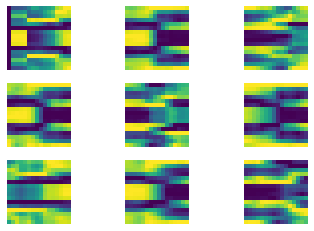

In [6]:
name = "filt_center_method"
data_path = f"{wd()}/data/{name}.npy" 

NO_OF_CLASSES = 3 # The number of classes in the dataset

im_data = np.load(data_path,allow_pickle=True)

print(f"{name} imdata shape: ",np.shape(im_data[0]))

# Split the dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(im_data[0], im_data[1][0], test_size=0.01, random_state=666)
X_train = np.stack(X_train)

def show_plot(examples, n):
	"""
	Finction to plot the loaded / generated data
	"""
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		X_plot = np.concatenate(examples[i]).reshape([16,16])
		plt.imshow(X_plot)
	plt.show()


show_plot(X_train,NO_OF_CLASSES)

# Discriminator

In [8]:
def define_discriminator(in_shape=(16,16,1), n_classes=5, depth = 64, dropout = .4):
	
    # label input
	in_label = Input(shape=(1,))  #Shape 1
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label) #Shape 1,10
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1] 
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1],1))(li) 
    
	# image input
	in_image = Input(shape=in_shape)
	# concat label as a channel
	merge = Concatenate()([in_image, li])
    
	# downsample: This part is same as unconditional GAN upto the output layer.
    #We will combine input label with input image and supply as inputs to the model. 
	fe = Conv2D(depth, (3,3), strides=(2,2), padding='same')(merge) #16x16x128
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(dropout)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)  #Shape=1
    
	# define model
    ##Combine input label with input image and supply as inputs to the model. 
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

test_discr = define_discriminator()
plot_model(test_discr, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


/home/gatis_2/Documents/MSc/MSc-snatch-analysis/project-env/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Generator

In [9]:
def define_generator(latent_dim, n_classes=5, depth = 64):
    
	# label input
	in_label = Input(shape=(1,))  #Input of dimension 1
	# embedding for categorical input
	li = Embedding(n_classes, 10)(in_label) #Shape 1,10
    
	# linear multiplication
	n_nodes = 8 * 8  # To match the dimensions for concatenation later in this step.  
	li = Dense(n_nodes)(li) #1,100
	# reshape to additional channel
	li = Reshape((8, 8, 1))(li)
    
    
	# image generator input
	in_lat = Input(shape=(latent_dim,))  #Input of dimension 100
    
	#While defining model inputs we will combine input label and the latent input.
	n_nodes = depth * 8 * 8
	gen = Dense(n_nodes)(in_lat)  
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((8, 8, depth))(gen) 
	# merge image gen and label input
	merge = Concatenate()([gen, li])  #(Extra channel corresponds to the label)
	# upsample to 16x16
	gen = Conv2DTranspose(depth, (4,4), strides=(2,2), padding='same')(merge) #16x16x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(1, (8,8), activation='tanh', padding='same')(gen) #32x32x1
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model   #Model not compiled as it is not directly trained like the discriminator.

test_gen = define_generator(100)
plot_model(test_gen, show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


# Gan

In [11]:
# #Generator is trained via GAN combined model. 
# define the combined generator and discriminator model, for updating the generator
# Discriminator is trained separately so here only generator will be trained by keeping
# the discriminator constant. 

def define_gan(g_model, d_model, lr_opt_gan, beta):
	d_model.trainable = False  #Discriminator is trained separately. So set to not trainable.
    
    ## connect generator and discriminator...
	# first, get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input  #Latent vector size and label size
	# get image output from the generator model
	gen_output = g_model.output  
    
	# generator image output and corresponding input label are inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=lr_opt_gan, beta_1=beta)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model


In [12]:
# load the dataset previously generated.
def load_real_samples():
	# load dataset
	global X_train, y_train
	X = X_train
	trainy = y_train
	X = (X - 127.5) / 127.5   #Generator uses tanh activation so rescale 
	return [X, trainy]

def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset  
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels and assign to y (don't confuse this with the above labels that correspond to cifar labels)
	y = ones((n_samples, 1))  #Label=1 indicating they are real
	return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=5):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples, n_classes=NO_OF_CLASSES)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return [images, labels_input], y

# train the generator and discriminator
# We loop through a number of epochs to train our Discriminator by first selecting
# a random batch of images from our true/real dataset.
# Then, generating a set of images using the generator. 
# Feed both set of images into the Discriminator. 
# Finally, set the loss parameters for both the real and fake images, as well as the combined loss. 
def train(
		plot_title,
		g_model,
		d_model,
		gan_model,
		dataset,
		latent_dim,
		n_epochs=100,
		n_batch=128,
		default_loss = .1
		):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)  						# the discriminator model is updated for a half batch of real samples 
                            							# and a half batch of fake samples, combined a single batch. 
														# manually enumerate epochs
	gloss = []
	dlossR = []
	dlossF = []
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			
      		# Train the discriminator on real and fake images, separately (half batch each)
      		# Research showed that separate training is more effective. 
			# get randomly selected 'real' samples
      		# get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)

      		# update discriminator model weights
      		# train_on_batch allows you to update weights based on a collection 
      		# of samples you provide
			d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            
			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            
			# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch, n_classes=NO_OF_CLASSES)
            
      		# The generator wants the discriminator to label the generated samples
      		# as valid (ones)
      		# This is where the generator is trying to trick discriminator into believing
      		# the generated image is true (hence value of 1 for y)	
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))

      		# Generator is part of combined model where it got directly linked with the discriminator
      		# Train the generator with latent_dim as x and 1 as y. 
      		# Again, 1 as the output as it is adversarial and if generator did a great
      		# job of folling the discriminator then the output would be 1 (true)
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			

		
		gloss.append(g_loss)
		dlossR.append(d_loss_real)
		dlossF.append(d_loss_fake)

		# stop training when the loss for the gan goes bellow certain value - used by optimisation
		if len(gloss) >2:
			if gloss[-1] <default_loss:
				print("dloss high enough")
				break
	
	# Plot the loss for the gan.
	plt.plot(range(i+1),gloss, label = "gloss")
	plt.plot(range(i+1),dlossR, label = "dlossR")
	plt.plot(range(i+1),dlossF, label = "dlossF")
	plt.title(plot_title)
	plt.legend()
	plt.show()
	# save the generator model

	model_save_name = f'{wd()}/data/{plot_title}.h5'
	g_model.save(model_save_name)
	print(model_save_name)
	
	return gloss


# Simple optimisation attempt
Following are the steps that will initiate training of a model for a set optimised hyperparameter values.

In [13]:
def model_optimisation():
  """
  The following function wraps the training function to make simple optimisation attempts easy.
  
  """

  opt_res_dic = {}
  default_loss = 0.05

  # !!!!!!! OPTIMISED PARAMETERS !!!!!!!

  # learning_rate_opt_gan = [0.001, 0.002, 0.003, 0.0005, 0.0001, 0.00005, 0.00001]
  # learning_rate_opt_gan = np.arange(0.002,0.005,0.0005)
  lr_opt_gan = 0.0025

  # beta_1_gan_opt = np.arange(0.1,1,0.1)
  # beta_1_gan_opt = np.arange(0.4,0.6,0.025)
  beta_1 = 0.45

  # dense_depth = [8 ,16, 32, 64, 128, 256]
  dense_depth = [4, 8, 12, 16, 20] 
  # dense_depth = np.arange(4,28,4) # 4 to 16 seems optimal
  # dense_depth = np.arange(2,7,1) # 4 to 16 seems optimal
  # depth = 16

  # dropout_rate = np.arange(0,1,.1) # 0.1 seems to have done the best
  # dropout_rate = np.arange(0,0.3,.05) # 0.15 seems to have done the best
  dropout = 0.15


  # for lr_opt_gan in learning_rate_opt_gan:
  # for beta_1 in beta_1_gan_opt:
  # for dropout in dropout_rate: 
  for depth in dense_depth: 
    title = f"depth_{depth}"
    print(f"Training {title}")
    #Train the GAN
    epochs = 10
    # size of the latent space
    latent_dim = 100
    # create the discriminator
    d_model = define_discriminator(depth=depth,n_classes=NO_OF_CLASSES,dropout=dropout)
    # create the generator
    g_model = define_generator(latent_dim,depth=depth,n_classes=NO_OF_CLASSES)
    # create the gan
    gan_model = define_gan(g_model, d_model,lr_opt_gan, beta_1)
    # load image data
    dataset = load_real_samples()
    # train model
    gloss = train(title, g_model, d_model, gan_model, dataset, latent_dim, n_epochs=epochs, default_loss = default_loss,n_batch=100)

    opt_res_dic[depth] =  gloss
  print("!!!! FINISH !!!!")
  return opt_res_dic

Train / optimise the model

In [ ]:
opt_res_dic = model_optimisation()

Print the minimum loss for the last optimisation cycle.

In [ ]:
for rate in opt_res_dic:
  print(f"{rate} best loss {np.min(opt_res_dic[rate])}")

4 best loss 0.1283290535211563
8 best loss 0.13332943618297577
12 best loss 0.16977697610855103
16 best loss 0.2229815423488617
20 best loss 0.3054099380970001


# Load a trained model and generate images from this model

depth_4.h5


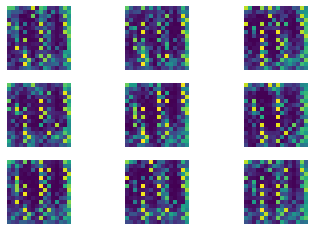

depth_8.h5


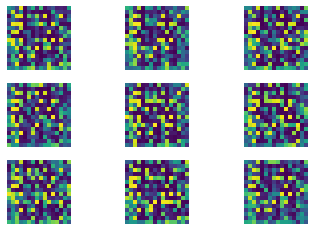

depth_12.h5


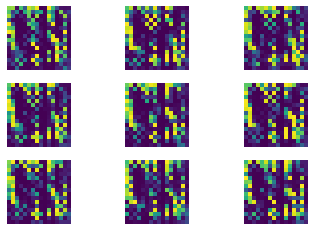

depth_16.h5


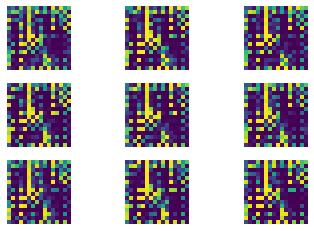

depth_20.h5


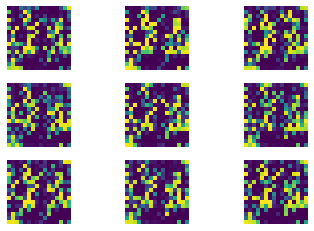

In [ ]:
for rate in opt_res_dic:
	name_plot_model = f"depth_{rate}.h5"
	model = load_model(f'{wd()}/data/{name_plot_model}')

	# generate multiple images
	latent_points, labels = generate_latent_points(100, NO_OF_CLASSES*NO_OF_CLASSES, n_classes=NO_OF_CLASSES)
	# specify labels - generate NO_OF_CLASSES sets of labels each gping from 0 to NO_OF_CLASSES-1
	labels = asarray([x for _ in range(NO_OF_CLASSES) for x in range(NO_OF_CLASSES)])
	# generate images
	X  = model.predict([latent_points, labels])
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	X = (X*255).astype(np.uint8)

	# plot the result (NO_OF_CLASSES sets of images, all images in a column should be of same class in the plot)
	print(name_plot_model)
	show_plot(X, NO_OF_CLASSES)